# Preprocess and Analyze
## Load data

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline

sns.set(style="whitegrid")

In [176]:
clean_data_file = "clean_lichess_games.csv"
# Load data
try:
    clean_df = pd.read_csv(clean_data_file)
    print("Cleaned dataset loaded successfully.")
except FileNotFoundError:
    print(f"File {clean_data_file} not found. Please ensure the file is in the correct directory.")

Cleaned dataset loaded successfully.


## Question 1: Average Number of Moves in Draws vs. Decisive Games

What is the average number of moves in games that end in a draw compared to games with a decisive result?

In [177]:
# Categorize game outcomes
clean_df['game_result'] = clean_df['winner'].apply(lambda x: 'Draw' if x == 'draw' else ('White Wins' if x == 'white' else 'Black Wins'))

# Create separate df for each outcome
df_draw = clean_df[clean_df['game_result'] == 'Draw']
df_white_wins = clean_df[clean_df['game_result'] == 'White Wins']
df_black_wins = clean_df[clean_df['game_result'] == 'Black Wins']

print(f"Number of Draws: {df_draw.shape[0]}")
print(f"Number of White Wins: {df_white_wins.shape[0]}")
print(f"Number of Black Wins: {df_black_wins.shape[0]}")

Number of Draws: 888
Number of White Wins: 9545
Number of Black Wins: 8680


In [178]:
# Average number of turns
avg_turns_draw = df_draw['turns'].mean()
avg_turns_white = df_white_wins['turns'].mean()
avg_turns_black = df_black_wins['turns'].mean()

print(f"Average Number of Turns in Draws: {avg_turns_draw:.2f}")
print(f"Average Number of Turns in White Wins: {avg_turns_white:.2f}")
print(f"Average Number of Turns in Black Wins: {avg_turns_black:.2f}")

Average Number of Turns in Draws: 87.16
Average Number of Turns in White Wins: 57.78
Average Number of Turns in Black Wins: 60.80


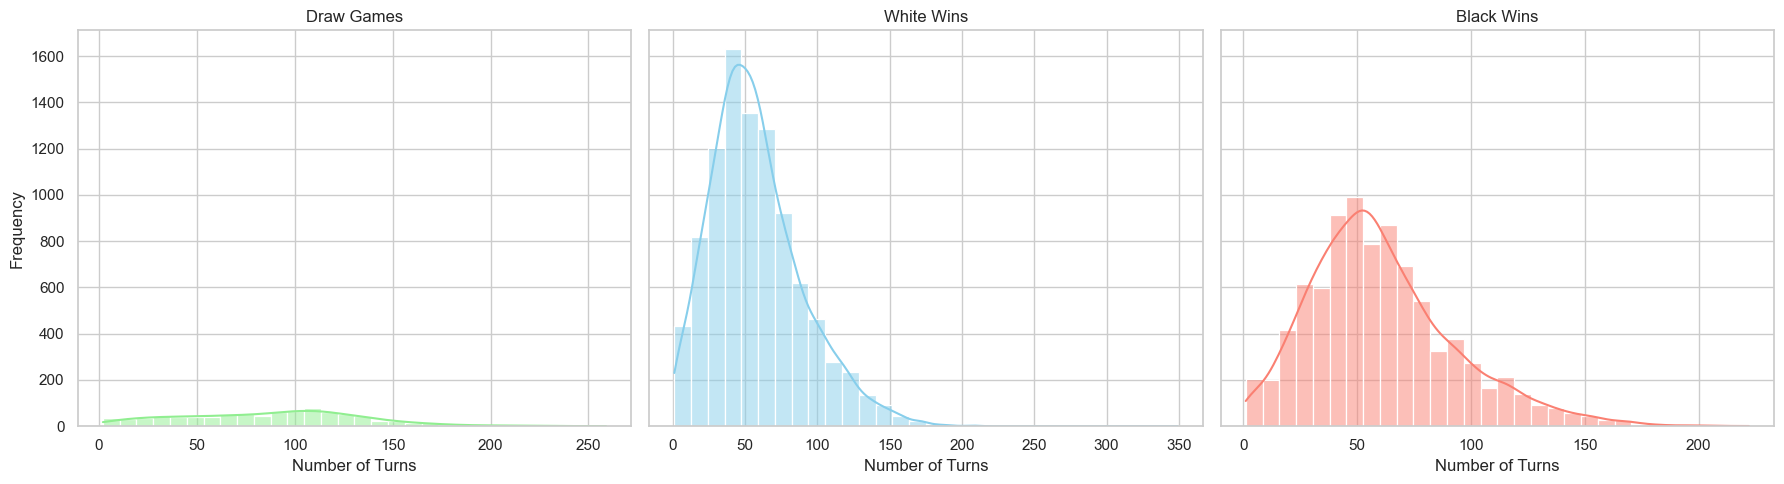

In [179]:
# Plot histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

sns.histplot(df_draw['turns'], bins=30, kde=True, color='lightgreen', ax=axes[0])
axes[0].set_title('Draw Games')
axes[0].set_xlabel('Number of Turns')
axes[0].set_ylabel('Frequency')

sns.histplot(df_white_wins['turns'], bins=30, kde=True, color='skyblue', ax=axes[1])
axes[1].set_title('White Wins')
axes[1].set_xlabel('Number of Turns')

sns.histplot(df_black_wins['turns'], bins=30, kde=True, color='salmon', ax=axes[2])
axes[2].set_title('Black Wins')
axes[2].set_xlabel('Number of Turns')

plt.tight_layout()
plt.show()

In [180]:
# Perform T-test between Draws and White Wins
from scipy.stats import ttest_ind

t_stat_white, p_val_white = ttest_ind(df_draw['turns'], df_white_wins['turns'], equal_var=False)
print(f"T-test between Draws and White Wins: t-statistic = {t_stat_white:.2f}, p-value = {p_val_white:.4f}")

# Perform T-test between Draws and Black Wins
t_stat_black, p_val_black = ttest_ind(df_draw['turns'], df_black_wins['turns'], equal_var=False)
print(f"T-test between Draws and Black Wins: t-statistic = {t_stat_black:.2f}, p-value = {p_val_black:.4f}")

T-test between Draws and White Wins: t-statistic = 18.57, p-value = 0.0000
T-test between Draws and Black Wins: t-statistic = 16.62, p-value = 0.0000


## Question 2: Most Common Openings by Player Rating

Which openings are most commonly used, and how do they vary by player rating?

In [181]:
# Define rating bins and labels
rating_bins = [0, 1100, 1600, 2000, 2300, 2600, np.inf]
rating_labels = ["Rookie", "Beginner", "Intermediate", "Advanced", "Expert", "GrandMaster"]

# Create categorical rating columns
clean_df['white_level'] = pd.cut(clean_df['white_rating'], bins=rating_bins, labels=rating_labels, right=False)
clean_df['black_level'] = pd.cut(clean_df['black_rating'], bins=rating_bins, labels=rating_labels, right=False)

# Verify the distribution
print(clean_df['white_level'].value_counts())
print(clean_df['black_level'].value_counts())

# Group data by opening and white_level
openings_by_rating = clean_df.groupby(['opening_name', 'white_level']).size().reset_index(name='count')

# Calculate the total games per rating category
total_games_per_rating = clean_df.groupby('white_level').size().reset_index(name='total_games')

# Merge and calculate percentages
openings_by_rating = openings_by_rating.merge(total_games_per_rating, on='white_level')
openings_by_rating['percentage'] = (openings_by_rating['count'] / openings_by_rating['total_games']) * 100

# Select top 10 openings per rating category
top_openings = openings_by_rating.sort_values(['white_level', 'count'], ascending=[True, False]).groupby('white_level').head(10)

# Define the order of ratings
rating_order = ["GrandMaster", "Expert", "Advanced", "Intermediate", "Beginner", "Rookie"]
top_openings['white_level'] = pd.Categorical(top_openings['white_level'], categories=rating_order, ordered=True)

# Sort openings within each rating by percentage
top_openings = top_openings.sort_values(['white_level', 'percentage'], ascending=[True, False])

# Display top_openings to verify
print(top_openings.head(20))

white_level
Beginner        9670
Intermediate    7078
Advanced        1512
Rookie           649
Expert           177
GrandMaster       27
Name: count, dtype: int64
black_level
Beginner        9755
Intermediate    6939
Advanced        1531
Rookie           712
Expert           160
GrandMaster       16
Name: count, dtype: int64
                                           opening_name  white_level  count  \
5765                                       Queen's Pawn  GrandMaster      3   
3179  Italian Game: Two Knights Defense |  Polerio D...  GrandMaster      2   
5525  Queen's Gambit Declined: Tartakower Variation ...  GrandMaster      2   
617          Bogo-Indian Defense: Nimzowitsch Variation  GrandMaster      1   
761              Caro-Kann Defense: Classical Variation  GrandMaster      1   
875                 Caro-Kann Defense: Modern Variation  GrandMaster      1   
917             Caro-Kann Defense: Tartakower Variation  GrandMaster      1   
2537             Gruenfeld Defense: Stoc

/var/folders/b4/dqvjht991812wpssc6sdmlj00000gn/T/ipykernel_57149/566187857.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  openings_by_rating = clean_df.groupby(['opening_name', 'white_level']).size().reset_index(name='count')
/var/folders/b4/dqvjht991812wpssc6sdmlj00000gn/T/ipykernel_57149/566187857.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_games_per_rating = clean_df.groupby('white_level').size().reset_index(name='total_games')
/var/folders/b4/dqvjht991812wpssc6sdmlj00000gn/T/ipykernel_57149/566187857.py:24: FutureWarning: The default of observed=False is deprecated and will be changed

/var/folders/b4/dqvjht991812wpssc6sdmlj00000gn/T/ipykernel_57149/3433501570.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


<Figure size 1500x1000 with 0 Axes>

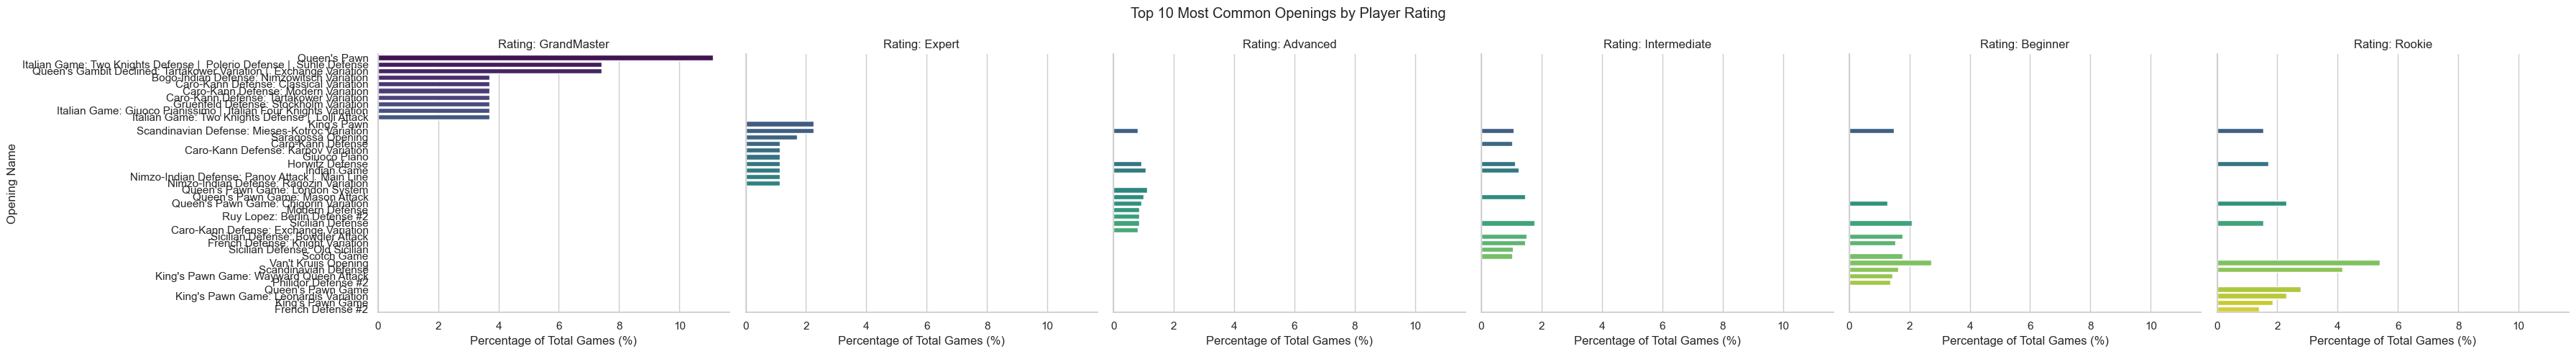

In [182]:
# Plot the top 10 openings by player rating
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")

g = sns.catplot(
    data=top_openings,
    x='percentage',
    y='opening_name',
    col='white_level',
    kind='bar',
    height=5,
    aspect=1.2,
    palette='viridis',
    order=None  # Removed the incorrect order parameter
)

g.set_titles("Rating: {col_name}")
g.set_axis_labels("Percentage of Total Games (%)", "Opening Name")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Top 10 Most Common Openings by Player Rating")
plt.tight_layout()
plt.show()

##  Question 10: How does the base time affect the result of the game (win/loss/draw)?

In [183]:
# Extract base time from 'increment_code'
clean_df['base_time'] = clean_df['increment_code'].apply(lambda x: int(x.split('+')[0]) if '+' in x else int(x))

In [184]:
# Group by base time and game result
result_by_base = clean_df.groupby(['base_time', 'game_result']).size().unstack(fill_value=0)

# Calculate percentage distribution
result_percentage = result_by_base.div(result_by_base.sum(axis=1), axis=0) * 100

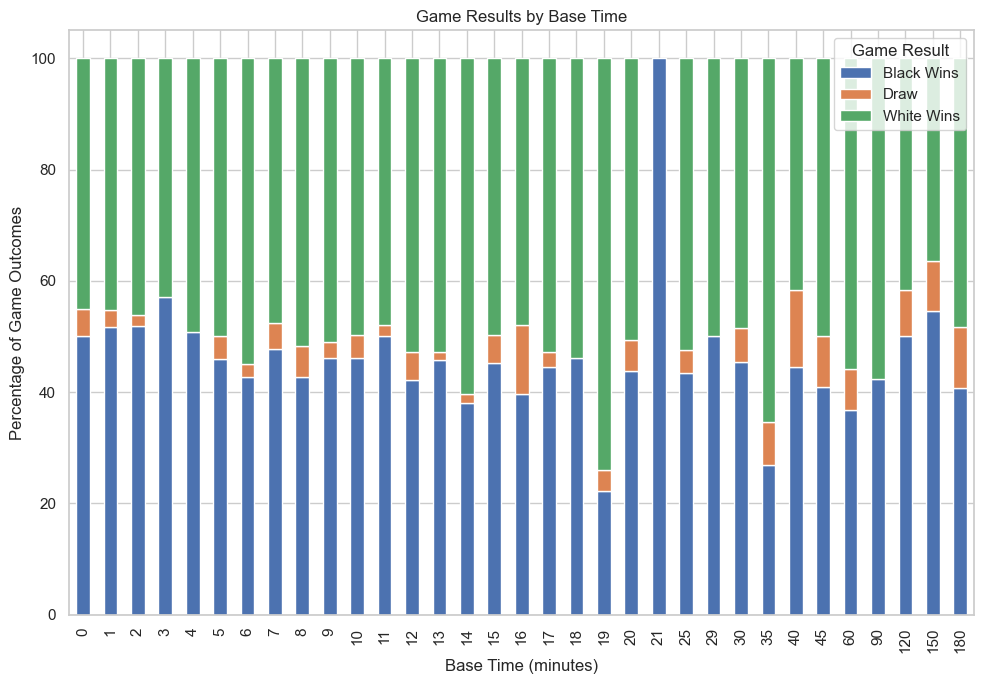

In [185]:
# Visualize the relationship
import matplotlib.pyplot as plt

result_percentage.plot(kind='bar', stacked=True, figsize=(10,7))
plt.title('Game Results by Base Time')
plt.xlabel('Base Time (minutes)')
plt.ylabel('Percentage of Game Outcomes')
plt.legend(title='Game Result')
plt.tight_layout()
plt.show()

## Question 4: Do highly rated players tend to win faster (fewer moves) than lower-rated players?

In [186]:
def get_rating_group(rating_label):
    if rating_label in ["Rookie", "Beginner", "Intermediate"]:
        return "Low"
    elif rating_label in ["Advanced", "Expert", "GrandMaster"]:
        return "High"
    return "Unknown"

clean_df['rating_group'] = clean_df['white_level'].apply(get_rating_group)

# 2. Convert match duration to minutes (example: last_move_at - created_at)
#    Assuming the timestamp columns are in milliseconds
clean_df['match_duration_mins'] = (clean_df['last_move_at'] - clean_df['created_at']) / 60000.0

# 3. Filter out rows with no valid duration
clean_df = clean_df[clean_df['match_duration_mins'] > 0]

# 4. Target only decisive games (optional)
decisive_df = clean_df[clean_df['winner'] != 'draw']

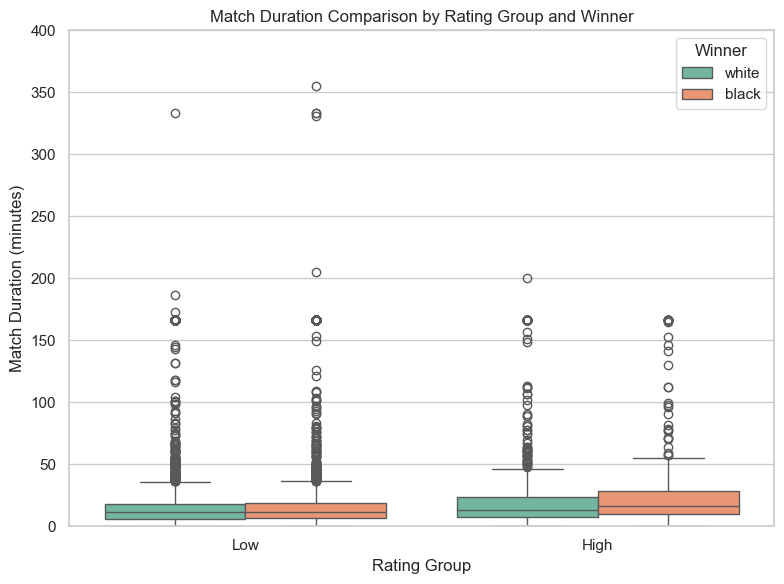

In [187]:
plt.figure(figsize=(8,6))
sns.boxplot(
    data=decisive_df,
    x='rating_group',
    y='match_duration_mins',
    hue='winner',
    palette='Set2'
)
plt.title("Match Duration Comparison by Rating Group and Winner")
plt.xlabel("Rating Group")
plt.ylabel("Match Duration (minutes)")
plt.legend(title='Winner', loc='upper right')
plt.ylim(0, 400) # Limit the y-axis to focus on the majority of data, some data dropped
plt.tight_layout()
plt.show()

## Question 6: Can player ratings, opening choices, and time increments be used to predict the winner of a game?

LogisticRegression Accuracy: 0.58
RandomForest Accuracy: 0.50


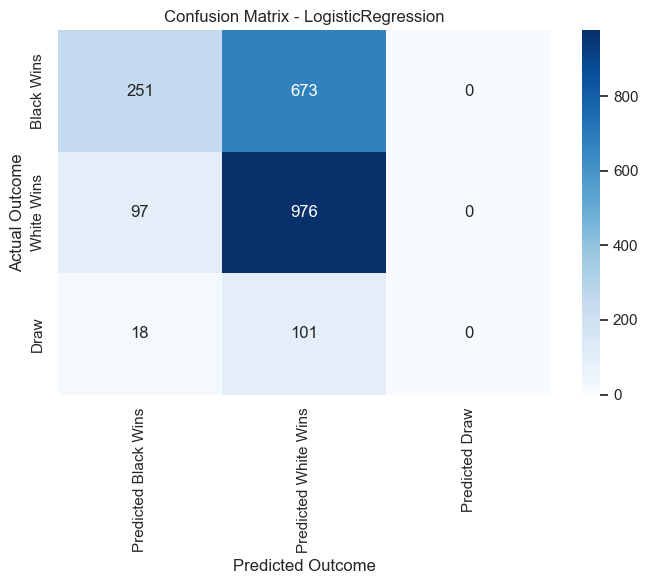

Best Model: LogisticRegression with Accuracy: 0.58


In [188]:
# Training and Evaluation for Question 6

# Initialize models
models = {
    'LogisticRegression': LogisticRegression(max_iter=2000),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Train models and evaluate accuracy
results = {}
for name, clf in models.items():
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.2f}")

# Select the best model based on accuracy
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
y_pred = best_model.predict(X_test)

# Confusion Matrix with Clear Labels
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
cm_df = pd.DataFrame(cm, index=["Black Wins", "White Wins", "Draw"],
                     columns=["Predicted Black Wins", "Predicted White Wins", "Predicted Draw"])

plt.figure(figsize=(7,6))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted Outcome')
plt.ylabel('Actual Outcome')
plt.tight_layout()
plt.show()

print(f"Best Model: {best_model_name} with Accuracy: {results[best_model_name]:.2f}")

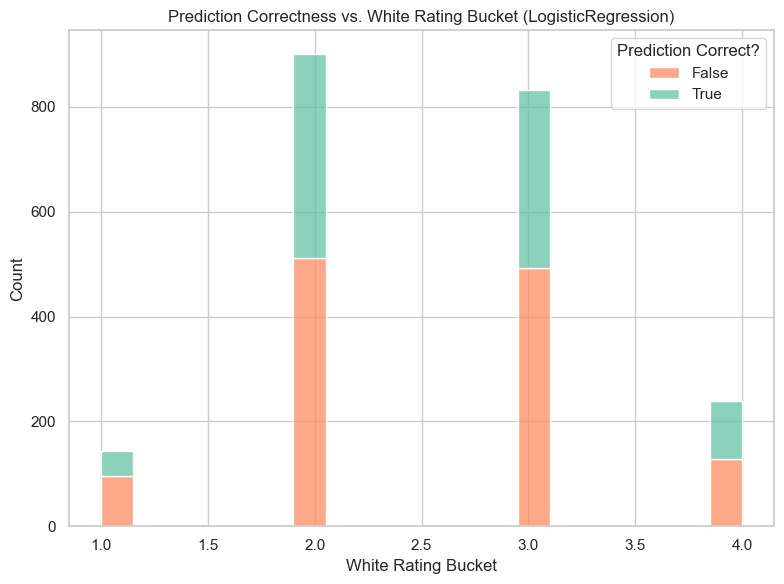

Accuracy: 0.5798676748582231


In [189]:
plt.figure(figsize=(8,6))
sns.histplot(
    x='white_bucket',
    hue=(y_pred == y_test),
    data=X_test.join(y_test),
    multiple='stack',
    palette='Set2'
)
plt.title(f"Prediction Correctness vs. White Rating Bucket ({best_model_name})")
plt.xlabel("White Rating Bucket")
plt.ylabel("Count")
plt.legend(title='Prediction Correct?', labels=['False','True'], loc='upper right')
plt.tight_layout()
plt.show()

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)


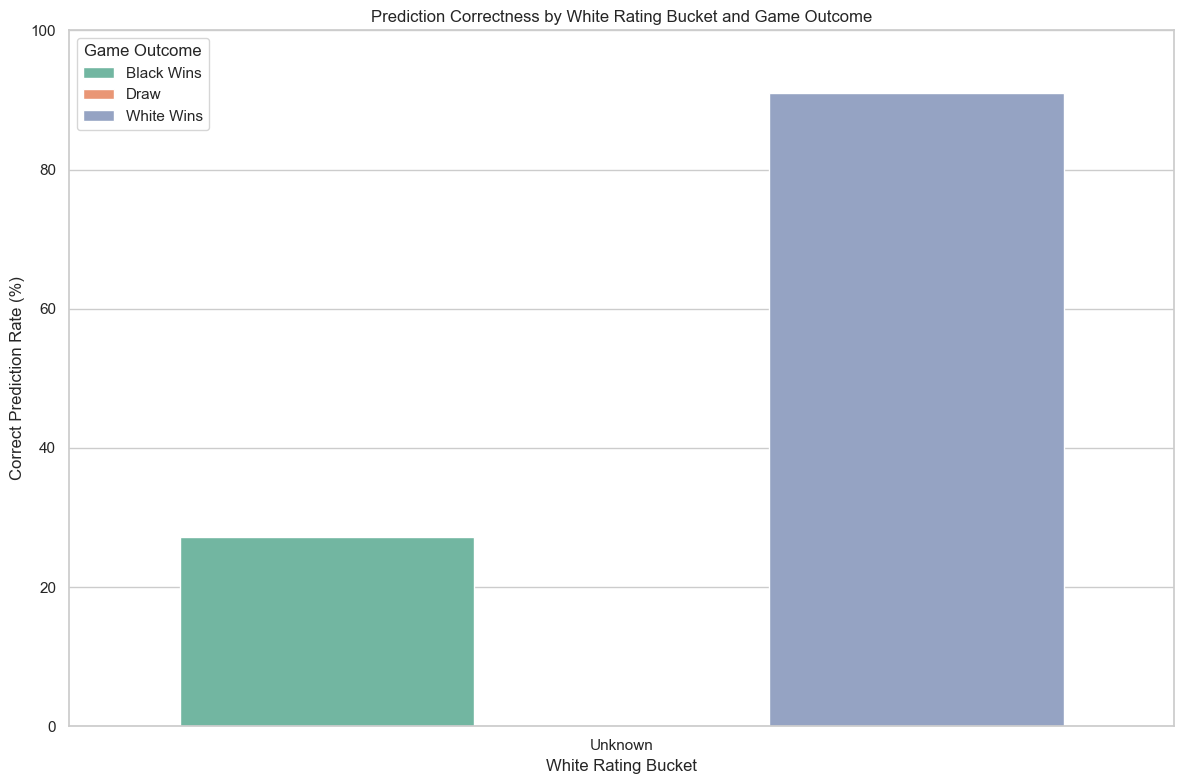

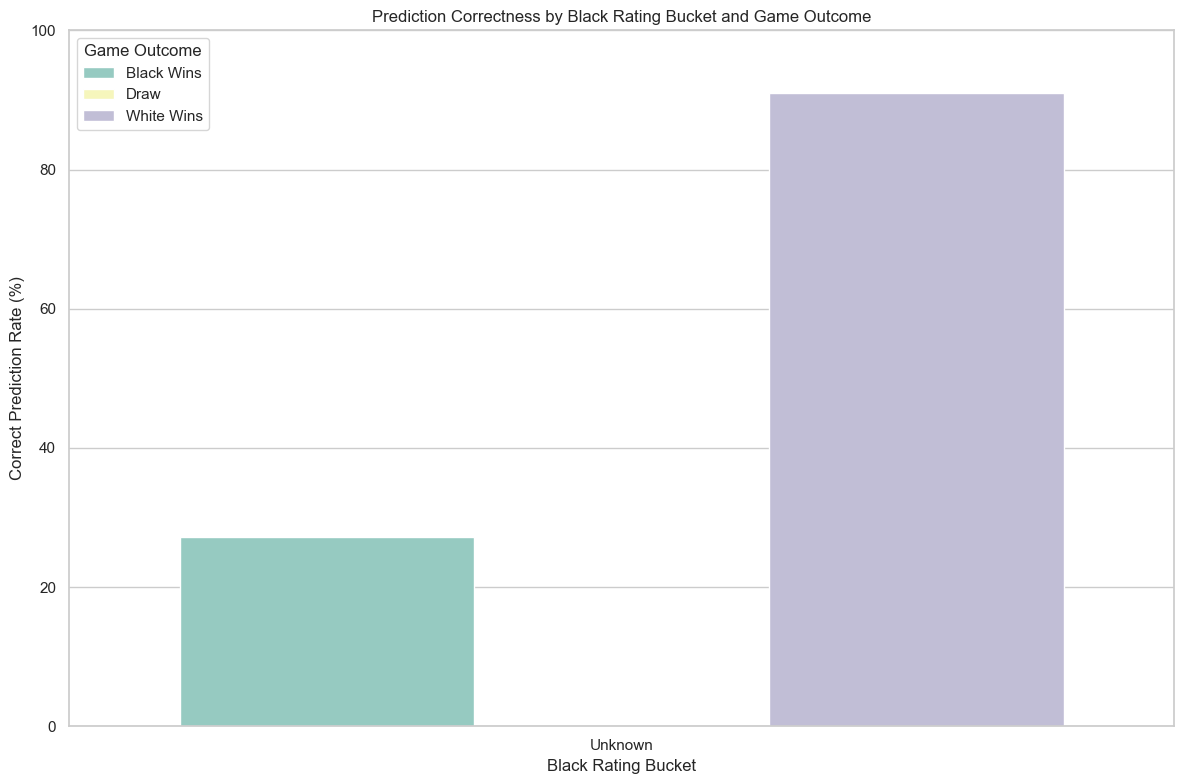

In [190]:
# Prediction Correctness Visualization for White and Black Rating Buckets

# Add predictions to the test set
X_test_result = X_test.copy()
X_test_result['Actual'] = y_test
X_test_result['Predicted'] = y_pred
X_test_result['Correct'] = X_test_result['Actual'] == X_test_result['Predicted']

# Add white and black bucket labels back
# Extract bucket names from one-hot encoded columns
white_buckets = [col for col in X_test.columns if col.startswith('white_bucket_')]
black_buckets = [col for col in X_test.columns if col.startswith('black_bucket_')]

# Function to get bucket name
def get_bucket(row, bucket_type):
    for bucket in bucket_type:
        if row[bucket] == 1:
            return bucket.replace(f"{bucket_type[0].split('_')[0]}_bucket_", "")
    return "Unknown"

X_test_result['White Rating Bucket'] = X_test_result.apply(lambda row: get_bucket(row, white_buckets), axis=1)
X_test_result['Black Rating Bucket'] = X_test_result.apply(lambda row: get_bucket(row, black_buckets), axis=1)

# Map winner codes to labels
winner_labels = {0: "Black Wins", 1: "White Wins", 2: "Draw"}
X_test_result['Actual Label'] = X_test_result['Actual'].map(winner_labels)
X_test_result['Predicted Label'] = X_test_result['Predicted'].map(winner_labels)

# Calculate correctness rates for White Rating Buckets
white_correct = X_test_result.groupby(['White Rating Bucket', 'Actual Label'])['Correct'].mean().reset_index()
white_correct['Correct (%)'] = white_correct['Correct'] * 100

# Plot for White Rating Buckets
plt.figure(figsize=(12,8))
sns.barplot(
    data=white_correct,
    x='White Rating Bucket',
    y='Correct (%)',
    hue='Actual Label',
    palette='Set2'
)
plt.title('Prediction Correctness by White Rating Bucket and Game Outcome')
plt.xlabel('White Rating Bucket')
plt.ylabel('Correct Prediction Rate (%)')
plt.legend(title='Game Outcome')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# Calculate correctness rates for Black Rating Buckets
black_correct = X_test_result.groupby(['Black Rating Bucket', 'Actual Label'])['Correct'].mean().reset_index()
black_correct['Correct (%)'] = black_correct['Correct'] * 100

# Plot for Black Rating Buckets
plt.figure(figsize=(12,8))
sns.barplot(
    data=black_correct,
    x='Black Rating Bucket',
    y='Correct (%)',
    hue='Actual Label',
    palette='Set3'
)
plt.title('Prediction Correctness by Black Rating Bucket and Game Outcome')
plt.xlabel('Black Rating Bucket')
plt.ylabel('Correct Prediction Rate (%)')
plt.legend(title='Game Outcome')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

In [191]:
# Summary of Model Performance

print(f"Model Comparison:")
for model_name, accuracy in results.items():
    print(f"{model_name}: {accuracy:.2f}")

print(f"\nBest Model: {best_model_name} with an accuracy of {results[best_model_name]:.2f}")

Model Comparison:
LogisticRegression: 0.58
RandomForest: 0.50

Best Model: LogisticRegression with an accuracy of 0.58
